# `planetviewer` Tutorial
Writted by Zachariah Milby [(zmilby@caltech.edu)](mailto:zmilby@caltech.edu)<br>
Created: September 3, 2024<br>
Modified: September 3, 2024

I wrote this notebook to demonstrate a few use cases of `planetviewer` for both ephemeris calculations and visualization.

In [1]:
# import general use packages and classes
from astropy.coordinates import Angle, SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

# set inline graphics to high resolution
%config InlineBackend.figure_format='retina'

# Ephemeris Calculations

## Example 1: Ephemeris Information for Jupiter as Observed from Maunakea on June 8, 2021 at 14:32:07 UTC

The first thing you must do is furnish (load) the SPICE kernels.

In [2]:
from planetviewer import load_spice_kernels
load_spice_kernels(download=False)

The fundamental arguments for any `planetviewer` calculation are the time of the observation (the observer epoch) and the observing location. We'll set those first.

In [3]:
from astropy.time import Time
time = Time('2021-06-08 14:32:07', scale='utc')
observer = 'Keck'

The fundamental object in `planetviewer` is `SolarSystemBody`. This class has many methods available to calculate ephemeris information.

In [4]:
from planetviewer import SolarSystemBody
planet = SolarSystemBody('Jupiter')

The README summarizes all of the available ephemeris methods, but we'll calculate a few here as an example.

In [5]:
# get the RA/Dec
coord = planet.get_skycoord(time=time, observer=observer)

# get distance from observer
distance = planet.get_observer_target_distance(time=time, observer=observer)

# get light travel time
lt = planet.get_light_travel_time(time=time, observer=observer)

# get phase angle
pang = planet.get_phase_angle(time=time, observer=observer)

# get apparent angular offset between Jupiter's center and Ganymede's center
satellite = SolarSystemBody('Ganymede')
offset = coord.spherical_offsets_to(satellite.get_skycoord(time=time, observer=observer))

# print out the results with proper string formatting
fmt = '%B %d, %Y at %H:%M:%S'
print(f'Ephemeris information for Jupiter on {time.strftime(fmt)} as observed from {observer}:')
print(f'   RA:                 {Angle(coord.ra).to_string(unit=u.hour)}')
print(f'   Dec:                {Angle(coord.dec).to_string(unit=u.deg)}')
print(f'   Distance:           {distance}')
print(f'   Light travel time:  {lt}')
print(f'   Phase angle:        {pang}')
print(f'   Ganymede offset:    ({offset[0]}, {offset[1]})')

Ephemeris information for Jupiter on June 08, 2021 at 14:32:07 as observed from Keck:
   RA:                 22h16m00.12174114s
   Dec:                -11d43m52.57683963s
   Distance:           698482972.5103773 km
   Light travel time:  2329.684596536104 s
   Phase angle:        11.150425650676803 deg
   Ganymede offset:    (-0.015822991047981672 deg, -0.00587935833044637 deg)


# Visualizations

## Example 1: The Uranus System During the Voyager 1 Flyby as Observed from Triton

In [6]:
objects = ['Uranus', 'Ariel', 'Umbriel', 'Titania', 'Oberon', 'Miranda']

local_time_at_uranus = Time('1977-03-10 19:59:59.527641', scale='utc')
observer = 'Triton'
lt = SolarSystemBody('Uranus').get_light_travel_time(time=local_time_at_uranus, observer=observer)
time = local_time_at_uranus + lt

We will want to plot these in order from furthest to closest. `sort_by_distance` will sort this list by distance from the observer.

In [7]:
from planetviewer import sort_by_distance
sorted_objects = sort_by_distance(objects, time=time, observer=observer)

sorted_objects

['Oberon', 'Umbriel', 'Ariel', 'Uranus', 'Titania', 'Miranda']

Now we need to set up the WCS axis for plotting, which requires defining the center and width of the field of view. The center needs to be an Astropy `SkyCoord` object, so we can just choose the position of Uranus. The `SolarSystemBody` class has a convenience method `parse_fov` for parsing the field of view. If you provide an `int` or `float`, it will assume you mean a multiple of the body's apparent angular radius. If you provide a length, it will convert that length at the target's distance to an angle. Finally, you can just directly provide an angle either as an Astropy `Angle` or `Quantity`. For the example below, we will use 12 Uranian radii.

We'll draw each object in distance-sorted order in a loop, and if the object is not Uranus, we will place a the name as a label in the upper right. The function `place_label` will place labels relative to the limb of an object and handle all of the necessary transforms.

Two other functions help ensure the projection is as expected. Use `set_standard_axis_limits` to ensure the axis limits match those you specified with your FOV. This is especially useful since Matplotlib will resize the data area to fit everything you've plotted. Use `set_standard_axis_labels` to automatically change the axis labels to say "Right Ascension (J2000)" and "Declination (J2000)".

> **NOTE**<br>
> The drawing process can take 10 seconds or more *per object* due to all of the necessary transformations.

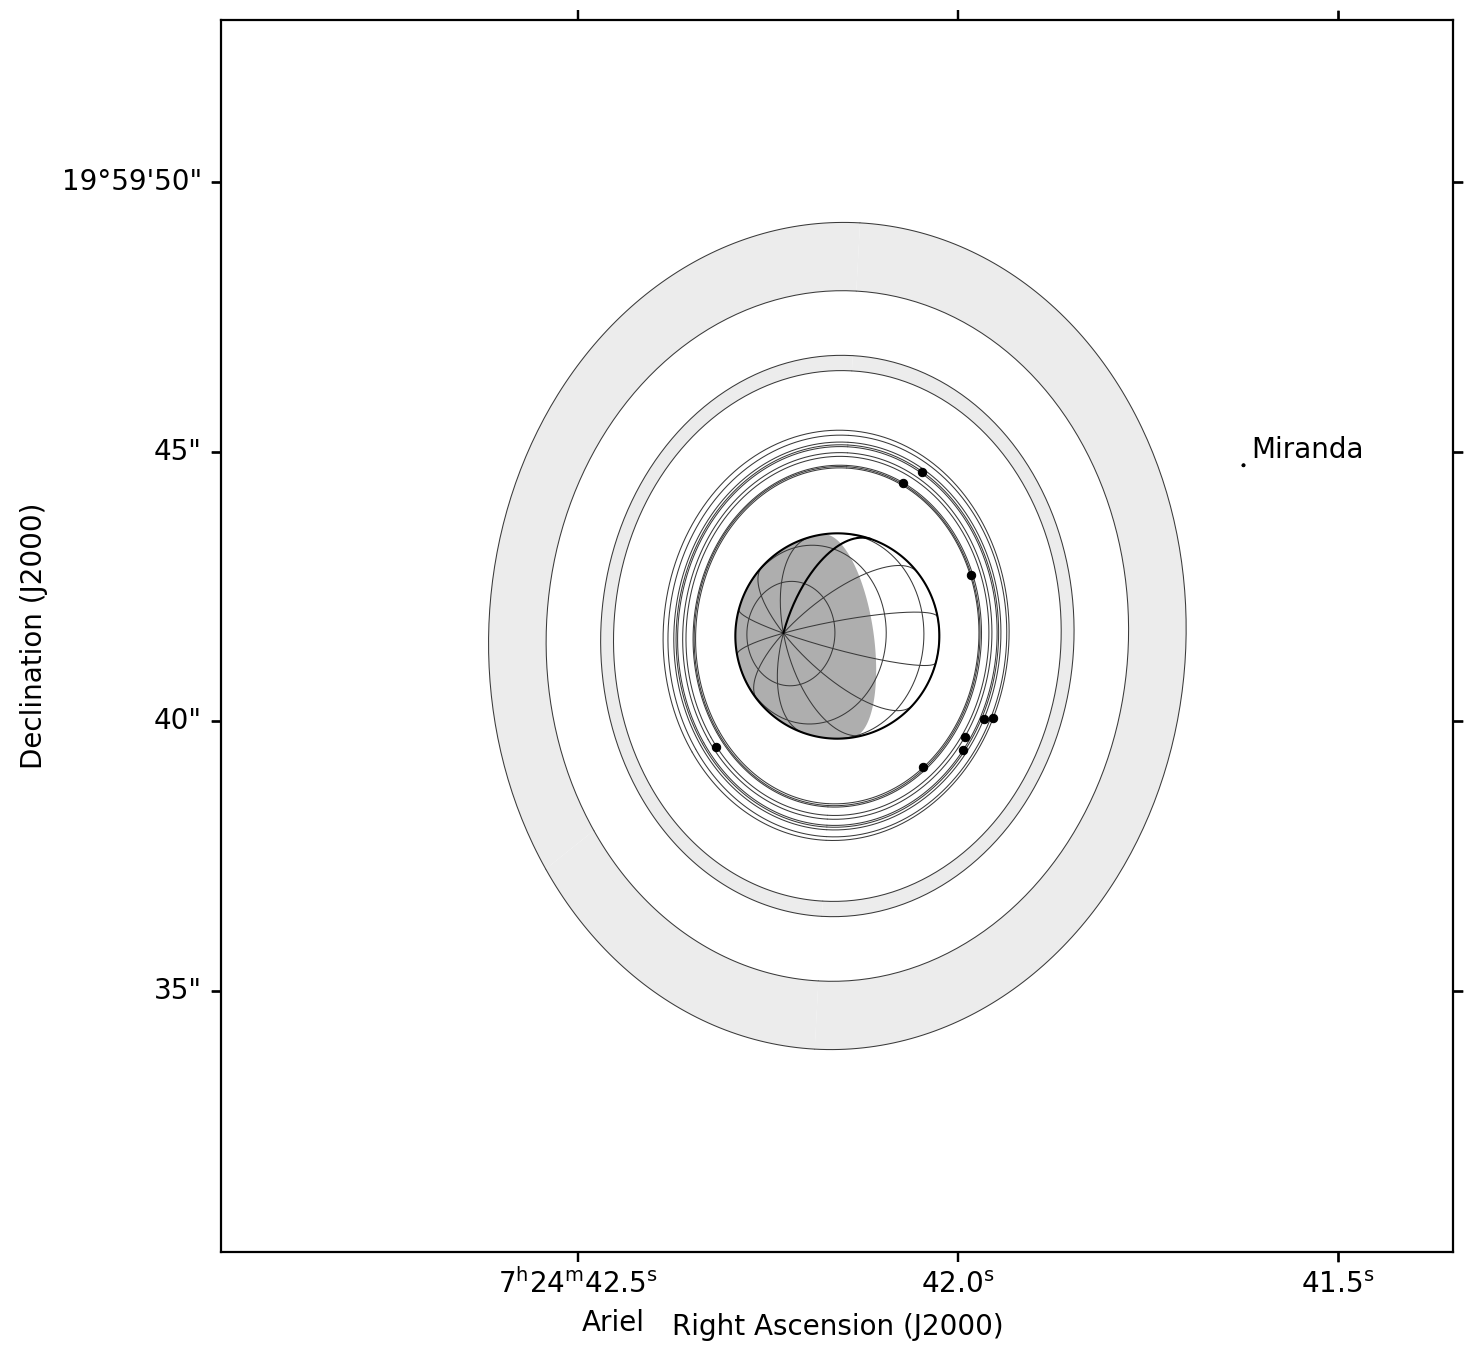

In [8]:
from planetviewer import make_wcs, set_standard_axis_limits, set_standard_axis_labels, place_label

# create WCS projection
ssb = SolarSystemBody('Uranus')
center = ssb.get_skycoord(time=time, observer=observer)
fov = ssb.parse_fov(time=time, observer=observer, fov=12)
wcs = make_wcs(center=center, fov=fov)

# make figure and axis
fig, axis = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection=wcs))
transform = axis.get_transform('world')

# draw each object
for obj in sorted_objects:
    ssb = SolarSystemBody(obj)
    ssb.draw(axis=axis, time=time, observer=observer, ring_pericenter_markers=True)
    
    # place a label if not uranus
    if obj != 'Uranus':
        coord = ssb.get_skycoord(time=time, observer=observer)
        radius = ssb.get_angular_radius(time=time, observer=observer)
        place_label(axis=axis, label=obj, position='upper right', coord=coord, body_radius=radius)

# set axis limits and labels
set_standard_axis_limits(axis)
set_standard_axis_labels(axis)

plt.show()

## Example 2: Triple Transit Captured by HST
Display the viewing geometry of the following image taken by HST on January 24, 2015 at 7:10 UT in standard RA/Dec coordinates with the shadows.
<div>
<img src="https://stsci-opo.org/STScI-01EVT2HAFTV3A3S8WQCQWJ0VAA.jpg" width="400"/>
</div>

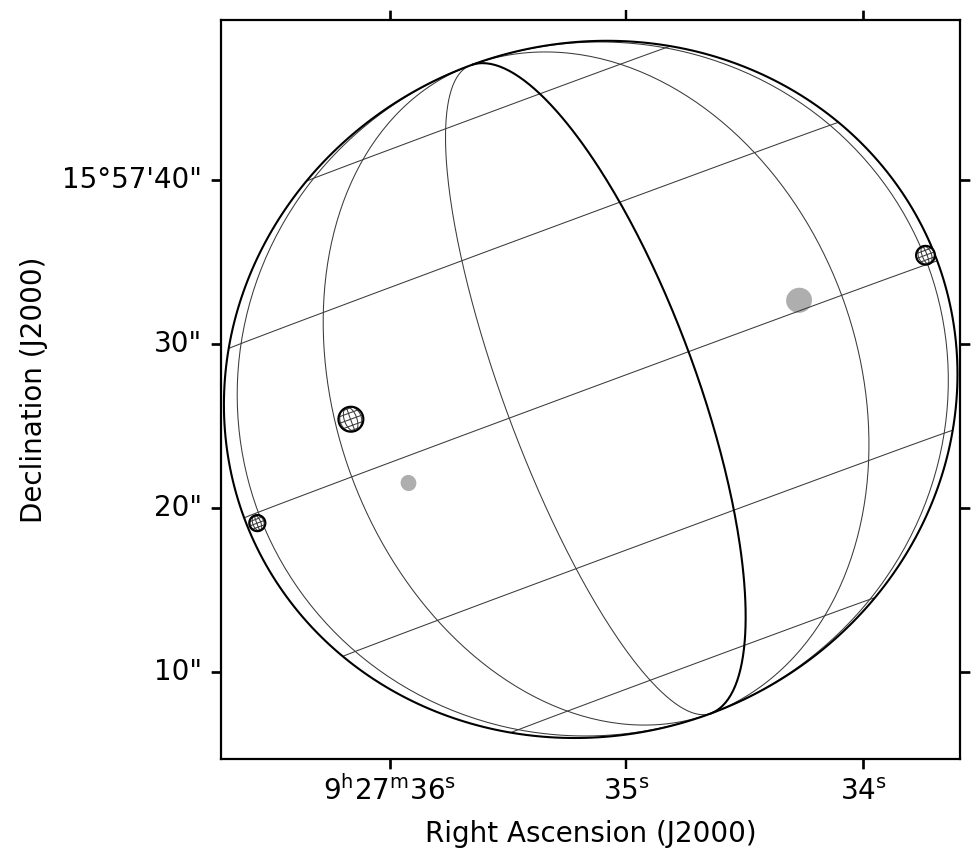

In [9]:
# set observation time and observer
time = Time('2015-01-24 07:10', scale='ut1')
observer = 'HST'

# all target bodies
targets = ['Jupiter', 'Io', 'Europa', 'Ganymede', 'Callisto']

# set up an axis centered on Jupiter
jupiter = SolarSystemBody('Jupiter')
fov = jupiter.parse_fov(time, observer, 2)
center = jupiter.get_skycoord(time, observer)
wcs = make_wcs(center, fov)
fig, axis = plt.subplots(subplot_kw=dict(projection=wcs))

# draw all the targets; providing the list `targets` as the keyword argument `shadow_casting_bodies` 
# means it will draw the shadows cast by each body on the others
for target in targets:
    ssb = SolarSystemBody(target)
    ssb.draw(axis, time, observer, rings='none', shadow_casting_bodies=targets)

# set axis limits and labels
set_standard_axis_limits(axis)
set_standard_axis_labels(axis)

## Example 3: Time Series Image of Enceladus Transiting Rhea as Observed by JWST

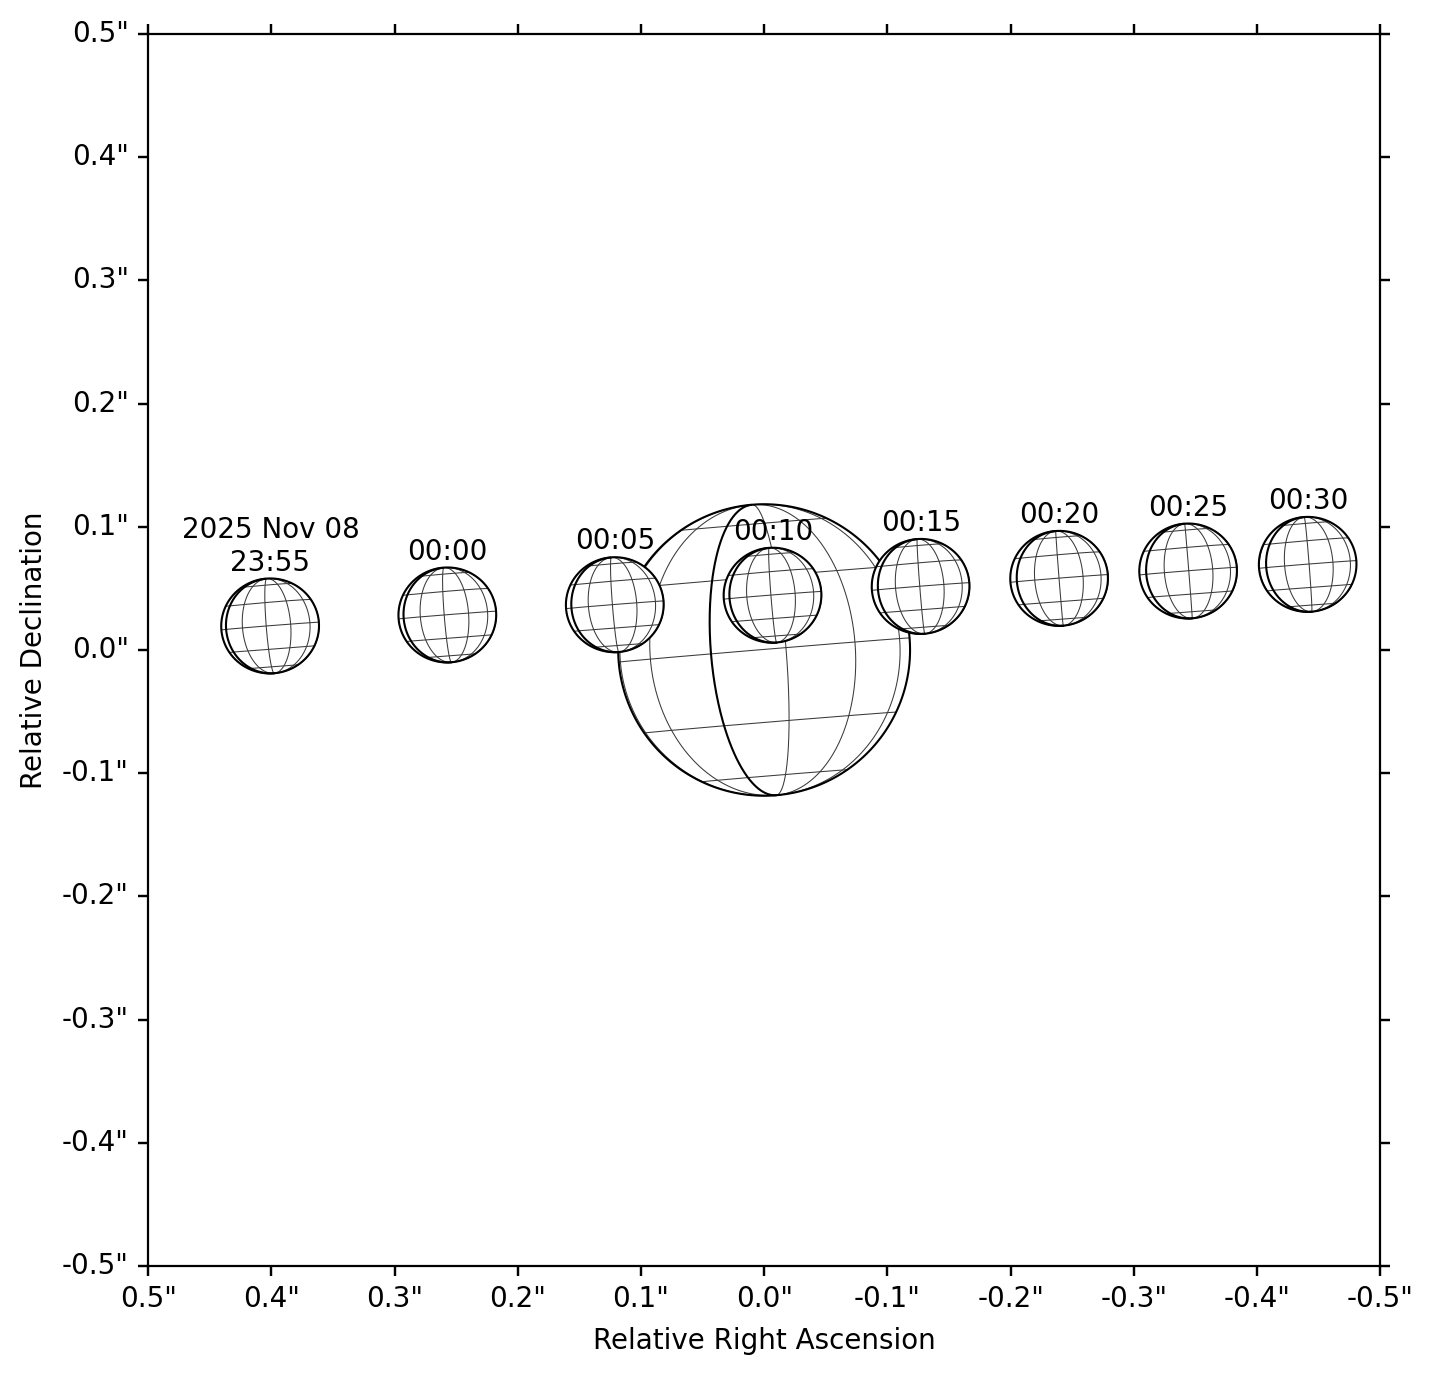

In [10]:
from planetviewer import convert_to_relative_axis

# set sequence times and observer 
times = Time('2025-11-08 23:55') + np.arange(0, 40, 5) * u.minute
observer = 'JWST'

# create target objects
targets = ['Rhea', 'Enceladus']
rhea = SolarSystemBody('Rhea')
enceladus = SolarSystemBody('Enceladus')

# set up an axis centered on Rhea at the midpoint of the times
midpoint_time = times[0] + (times[-1] - times[0]) / 2
center = rhea.get_skycoord(time=midpoint_time, observer=observer)
fov = rhea.parse_fov(time=midpoint_time, observer=observer, fov=Angle(1, unit='arcsec'))
wcs = make_wcs(center=center, fov=fov)

# make figure and axis
fig, axis = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection=wcs))

# draw Rhea at the midpoint time
rhea.draw(axis=axis, time=midpoint_time, observer=observer, shadow_casting_bodies=targets)
refcoord = rhea.get_skycoord(time=midpoint_time, observer=observer)

# draw Enceladus offset relative to the disk center of Rhea
for i, time in enumerate(times):
    
    # calculate the offset of Rhea between now and the midpoint time
    dra, ddec = rhea.get_offset(time, observer, refcoord)

    # draw Enceladus, removing the Rhea-to-Rhea offset
    enceladus.draw(axis=axis, time=time, observer=observer, dra=-dra, ddec=-ddec, 
                   shadow_casting_bodies=targets)
    
    # label each one with the time; include the date in the first label
    if i == 0:
        label = time.strftime('%Y %b %d') + '\n' + time.strftime('%H:%M')
    else:
        label = time.strftime('%H:%M')
    coord = enceladus.get_skycoord(time=time, observer=observer)
    radius = enceladus.get_angular_radius(time=time, observer=observer)
    place_label(axis=axis, label=label, position='upper center', coord=coord, 
                body_radius=radius, dra=-dra, ddec=-ddec)

# make axis into RA/Dec offset from center
convert_to_relative_axis(center=center, axis=axis)

# set units and spacing
axis.overlay_coords['lon'].set_major_formatter('s.s')
axis.overlay_coords['lat'].set_major_formatter('s.s')
axis.overlay_coords['lon'].set_ticks(spacing=0.1*u.arcsec)
axis.overlay_coords['lat'].set_ticks(spacing=0.1*u.arcsec)

# set axis limits
set_standard_axis_limits(axis)

## Example 4: Animation of Ganymede Passing into Eclipse Behind Jupiter as Observed from Maunakea

In [11]:
# set specific parameters for this plot
import matplotlib.animation as animation
from IPython.display import HTML
plt.rc('animation', html='jshtml')
plt.rc('animation', embed_limit=64.0)

# set sequence times and observer; 
times = Time('2021-06-08 12:35') + np.arange(0, 20, 1) * u.minute
observer = 'Keck'

# set targets
targets = {key: SolarSystemBody(key) for key in ['Jupiter', 'Io', 'Europa', 'Ganymede', 'Callisto']}

# set up a figure and axis
fig = plt.figure(figsize=(6, 6))

# general offset to make room for the inset axis
offset_ra, offset_dec = Angle(40, unit='arcsec'), Angle(40, unit='arcsec')

def func(i):
    
    # remove existing axes
    [ax.remove() for ax in fig.axes]
    
    # create WCS for the primary axis
    center1 = targets['Jupiter'].get_skycoord(time=times[i], observer=observer)
    center1 = SkyCoord(ra=center1.ra.deg - offset_ra.deg, dec=center1.dec.deg - offset_dec.deg, unit='deg')
    fov1 = targets['Jupiter'].parse_fov(time=times[i], observer=observer, fov=Angle(400, unit='arcsec'))
    wcs1 = make_wcs(center=center1, fov=fov1)
    
    # create WCS for the inset axis
    center2 = targets['Ganymede'].get_skycoord(time=times[i], observer=observer)
    fov2 = targets['Ganymede'].parse_fov(time=times[i], observer=observer, fov=3)
    wcs2 = make_wcs(center=center2, fov=fov2)
    
    # make axes again
    axis = fig.add_subplot(111, projection=wcs1)
    inset_axis = axis.inset_axes([0.65, 0.05, 0.3, 0.3], projection=wcs2)
    
    # turn off ticks, labels, etc. on inset axis
    ra = inset_axis.coords['ra']
    dec = inset_axis.coords['dec']
    ra.set_ticks_visible(False)
    ra.set_ticklabel_visible(False)
    dec.set_ticks_visible(False)
    dec.set_ticklabel_visible(False)
    ra.set_axislabel('')
    dec.set_axislabel('')
    
    # draw Jupiter
    for key, target in targets.items():
        if key == 'Jupiter':
            target.draw(axis=axis, time=times[i], observer=observer, rings='Main', 
                        shadow_casting_bodies=targets.keys())
        elif key == 'Ganymede':
            # draw Ganymede in both axes
            [target.draw(axis=ax, time=times[i], observer=observer, shadow_casting_bodies=targets.keys()) 
             for ax in [axis, inset_axis]]
        else:
            target.draw(axis=axis, time=times[i], observer=observer, shadow_casting_bodies=targets.keys())
    
    # annotate time in the upper corner
    transform = axis.get_transform('world')
    axis.annotate(times[i].strftime('%Y-%m-%d %H:%M:%S'), xy=(1, 1), xycoords='axes fraction',
                  xytext=(-5, -5), textcoords='offset points', ha='right', va='top')
    
    # set axis limits and labels
    [set_standard_axis_limits(ax) for ax in [axis, inset_axis]]
    set_standard_axis_labels(axis)
    
anim = animation.FuncAnimation(fig, func, frames=tqdm(range(len(times))))
plt.close()
HTML(anim.to_html5_video())

  0%|          | 0/20 [00:00<?, ?it/s]